# Cloud Coverage (`ccov`) 
`ccov` is extracted from the daily measurement file. The variable `CCOV` is used which is `Cloud cover fraction, which is in percent.` 

In [10]:
# Load required libraries for NetCDF processing
library(ncdf4)
library(dplyr)

# Check if NetCDF file exists and open it
nc_file_path <- file.path("../data/01_data_prep/07_era5_cloud_cover_2004-2023.nc")

if (!file.exists(nc_file_path)) {
    stop("NetCDF file not found. Please ensure the ERA5 cloud cover data has been downloaded first.")
}

# Open the NetCDF file
nc_data <- nc_open(nc_file_path)

print("=== EXTRACTING CLOUD COVER DATA ===")

# Get dimension information
lon <- ncvar_get(nc_data, "longitude")
lat <- ncvar_get(nc_data, "latitude")
time <- ncvar_get(nc_data, "valid_time")

print(sprintf("Longitude: %.4f", lon))
print(sprintf("Latitude: %.4f", lat))
print(sprintf("Time points: %d", length(time)))

# Extract total cloud cover data
tcc_data <- ncvar_get(nc_data, "tcc")
print(sprintf("Cloud cover data dimensions: %s", paste(dim(tcc_data), collapse = " x ")))

# Convert time from hours since reference to dates
time_units <- ncatt_get(nc_data, "valid_time", "units")$value
print(sprintf("Time units: %s", time_units))

# Improved time conversion logic
if (grepl("seconds since", time_units)) {
    # Extract reference date from units string
    ref_date_str <- sub(".*since ", "", time_units)
    ref_date_str <- trimws(ref_date_str)
    
    # Parse reference date
    if (grepl("\\d{4}-\\d{2}-\\d{2}", ref_date_str)) {
        ref_date <- as.POSIXct(ref_date_str, format = "%Y-%m-%d", tz = "UTC")
        if (is.na(ref_date)) {
            ref_date <- as.POSIXct(substr(ref_date_str, 1, 10), format = "%Y-%m-%d", tz = "UTC")
        }
    } else {
        ref_date <- as.POSIXct("1970-01-01 00:00:00", tz = "UTC")
    }
    
    # Convert seconds to dates
    dates <- as.Date(ref_date + time, tz = "UTC")
    
} else if (grepl("hours since", time_units)) {
    # Extract reference date from units string
    ref_date_str <- sub(".*since ", "", time_units)
    ref_date_str <- trimws(ref_date_str)
    
    # Parse reference date more robustly
    if (grepl("\\d{4}-\\d{2}-\\d{2}", ref_date_str)) {
        ref_date <- as.POSIXct(ref_date_str, format = "%Y-%m-%d %H:%M:%S", tz = "UTC")
        if (is.na(ref_date)) {
            ref_date <- as.POSIXct(substr(ref_date_str, 1, 10), format = "%Y-%m-%d", tz = "UTC")
        }
    } else {
        ref_date <- as.POSIXct("1900-01-01 00:00:00", tz = "UTC")
    }
    
    # Convert hours to dates
    dates <- as.Date(ref_date + time * 3600, tz = "UTC")
    
} else if (grepl("days since", time_units)) {
    # Extract reference date from units string
    ref_date_str <- sub(".*since ", "", time_units)
    ref_date_str <- trimws(ref_date_str)
    
    if (grepl("\\d{4}-\\d{2}-\\d{2}", ref_date_str)) {
        ref_date <- as.Date(substr(ref_date_str, 1, 10), format = "%Y-%m-%d")
    } else {
        ref_date <- as.Date("1900-01-01")
    }
    
    dates <- ref_date + as.numeric(time)
    
} else {
    # Default fallback - assume days since 1900-01-01
    ref_date <- as.Date("1900-01-01")
    dates <- ref_date + as.numeric(time)
}

# Ensure dates are properly formatted
dates <- as.Date(dates)

print(sprintf("Converted time range: %s to %s", min(dates), max(dates)))

# Create data frame with cloud cover time series
cloud_cover_ts <- data.frame(
    date = dates,
    cloud_cover = as.numeric(tcc_data),
    stringsAsFactors = FALSE
)

# Remove any missing values and sort by date
cloud_cover_ts <- cloud_cover_ts %>%
    filter(!is.na(cloud_cover), !is.na(date)) %>%
    arrange(date)

# Ensure date column is properly formatted as yyyy-mm-dd
cloud_cover_ts$date <- as.Date(cloud_cover_ts$date)

print(sprintf("Extracted %d cloud cover observations", nrow(cloud_cover_ts)))
print(sprintf("Date range: %s to %s", min(cloud_cover_ts$date), max(cloud_cover_ts$date)))
print(sprintf("Cloud cover range: %.3f to %.3f", 
              min(cloud_cover_ts$cloud_cover), max(cloud_cover_ts$cloud_cover)))

# Close the NetCDF file
nc_close(nc_data)

# Save the cloud cover data as csv file
cloud_cover_file <- file.path("../data/01_data_prep", "07_era5_cloud_cover_2004-2023.csv")
write.csv(cloud_cover_ts, cloud_cover_file, row.names = FALSE)
print(sprintf("✓ Cloud cover data saved: %s", cloud_cover_file))

# Preview the data
print("\n=== CLOUD COVER DATA PREVIEW ===")
print(head(cloud_cover_ts, 10))
print("Summary statistics:")
summary(cloud_cover_ts$cloud_cover)
print(sprintf("Cloud cover data contains %d records", nrow(cloud_cover_ts)))

[1] "=== EXTRACTING CLOUD COVER DATA ==="
[1] "Longitude: 7.7300"
[1] "Latitude: 47.2700"
[1] "Time points: 7305"
[1] "Cloud cover data dimensions: 7305"
[1] "Time units: seconds since 1970-01-01"
[1] "Converted time range: 2004-01-01 to 2023-12-31"
[1] "Longitude: 7.7300"
[1] "Latitude: 47.2700"
[1] "Time points: 7305"
[1] "Cloud cover data dimensions: 7305"
[1] "Time units: seconds since 1970-01-01"
[1] "Converted time range: 2004-01-01 to 2023-12-31"
[1] "Extracted 7305 cloud cover observations"
[1] "Date range: 2004-01-01 to 2023-12-31"
[1] "Cloud cover range: 0.000 to 1.000"
[1] "Extracted 7305 cloud cover observations"
[1] "Date range: 2004-01-01 to 2023-12-31"
[1] "Cloud cover range: 0.000 to 1.000"
[1] "<U+2713> Cloud cover data saved: ../data/01_data_prep/07_era5_cloud_cover_2004-2023.csv"
[1] "\n=== CLOUD COVER DATA PREVIEW ==="
         date cloud_cover
1  2004-01-01   1.0000000
2  2004-01-02   0.9373863
3  2004-01-03   1.0000000
4  2004-01-04   0.7758400
5  2004-01-05   0.8

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.4057  0.7963  0.6707  0.9810  1.0000 

[1] "Cloud cover data contains 7305 records"


In [11]:
# read the ccov data
ccov_data <- read.csv(cloud_cover_file, stringsAsFactors = FALSE)
print(sprintf("✓ Cloud cover data loaded from: %s", cloud_cover_file))

# Preview the loaded data
print("\n=== LOADED CLOUD COVER DATA PREVIEW ===")
print(head(ccov_data, 10))

# add a new column using cloud_cover as a percentage
ccov_data <- ccov_data %>%
    mutate(cloud_cover_percentage = cloud_cover * 100) %>%
    select(date, cloud_cover, cloud_cover_percentage)
print("Added cloud_cover_percentage column to the data.")
# Save the updated data with percentage in the same file
write.csv(ccov_data, cloud_cover_file, row.names = FALSE)
print(sprintf("✓ Updated cloud cover data saved with percentage: %s", cloud_cover_file))

[1] "<U+2713> Cloud cover data loaded from: ../data/01_data_prep/07_era5_cloud_cover_2004-2023.csv"
[1] "\n=== LOADED CLOUD COVER DATA PREVIEW ==="
         date cloud_cover
1  2004-01-01   1.0000000
2  2004-01-02   0.9373863
3  2004-01-03   1.0000000
4  2004-01-04   0.7758400
5  2004-01-05   0.8695803
6  2004-01-06   0.9965465
7  2004-01-07   0.9865927
8  2004-01-08   0.9993828
9  2004-01-09   0.9055674
10 2004-01-10   0.7513475
[1] "Added cloud_cover_percentage column to the data."
[1] "\n=== LOADED CLOUD COVER DATA PREVIEW ==="
         date cloud_cover
1  2004-01-01   1.0000000
2  2004-01-02   0.9373863
3  2004-01-03   1.0000000
4  2004-01-04   0.7758400
5  2004-01-05   0.8695803
6  2004-01-06   0.9965465
7  2004-01-07   0.9865927
8  2004-01-08   0.9993828
9  2004-01-09   0.9055674
10 2004-01-10   0.7513475
[1] "Added cloud_cover_percentage column to the data."
[1] "<U+2713> Updated cloud cover data saved with percentage: ../data/01_data_prep/07_era5_cloud_cover_2004-2023.csv"
[1] 

[1] "<U+2713> Cloud cover plot saved to ../data/01_data_prep/trend_plots/07_cloud_cover_plot.png"


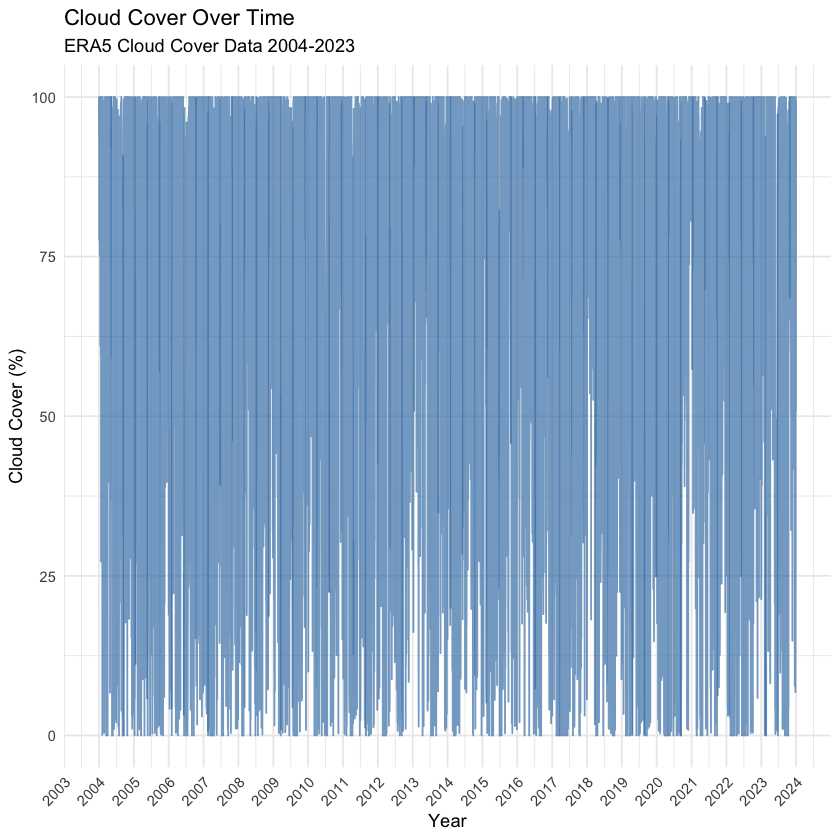

In [13]:
# Load ggplot2 for plotting
library(ggplot2)
library(lubridate)

# Add year column for plotting
ccov_data$year <- year(as.Date(ccov_data$date))

# Create a time series plot of cloud cover
plot_ccov <- ggplot(ccov_data, aes(x = as.Date(date), y = cloud_cover_percentage)) +
    geom_line(alpha = 0.7, size = 0.5, color = "steelblue") +
    scale_x_date(date_labels = "%Y", date_breaks = "1 years") +
    labs(title = "Cloud Cover Over Time",
         x = "Year",
         y = "Cloud Cover (%)",
         subtitle = "ERA5 Cloud Cover Data 2004-2023") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Display the plot
print(plot_ccov)

# Create the directory for trend plots if it does not exist
if (!dir.exists("../data/01_data_prep/trend_plots")) {
    dir.create("../data/01_data_prep/trend_plots", recursive = TRUE)
}

# Save the plot as a PNG file
ggsave("../data/01_data_prep/trend_plots/07_cloud_cover_plot.png", 
       plot = plot_ccov, width = 12, height = 5, bg = "white", dpi = 300)

print("✓ Cloud cover plot saved to ../data/01_data_prep/trend_plots/07_cloud_cover_plot.png")